*Authors:* Ismael Mendoza, Andrii Torchylo

In this tutorial, we go through some of the additional features available in the `metrics` module of btk.

# Setup 

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import galsim

In [ ]:
import btk
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions

# Generate some data

Let's generate some data with BTK that we can use to test the different aspects of the `metrics` module.

In [ ]:
from btk.sampling_functions import DefaultSampling
from btk.catalog import CatsimCatalog
from btk.survey import get_surveys
from btk.survey import Survey
from btk.draw_blends import CatsimGenerator
from btk.deblend import SepSingleBand

catalog_file = "../data/input_catalog.fits"
catalog = CatsimCatalog.from_file(catalog_file)

_ = catalog.get_raw_catalog()

survey: Survey = get_surveys("LSST")

stamp_size = 24.0
max_shift = 3.0
max_n_sources = 7
sampling_function = DefaultSampling(
    max_number=max_n_sources,
    min_number=1,
    stamp_size=stamp_size,
    max_shift=max_shift,
    max_mag=25.3,
    seed=0,
)

batch_size = 10

draw_generator = CatsimGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    njobs=1,
    add_noise="all",
    seed=0,
)

# generate batch 100 blend catalogs and images.
blend_batch = next(draw_generator)

# deblend with SEP to get predictions
deblender = SepSingleBand(
    max_n_sources=max_n_sources,  # same as above
    thresh=3,  # threshold pixel value for detection (see SEP docs)
    use_band=2,  # measure on 'r' band
)
deblend_batch = deblender(blend_batch, njobs=1)

In [ ]:
# examine output
blend_batch, deblend_batch

(BlendBatch(survey_name=LSST, 
 	 blend_images: np.ndarray, shape [10, 6, 120, 120]
 	 isolated_images: np.ndarray, shape [10, 7, 6, 120, 120]
 	 catalog_list: list of <class 'astropy.table.table.Table'>, size 10
 	 psfs: list of <class 'galsim.gsobject.GSObject'>, size 6
 	 wcs: <class 'astropy.wcs.wcs.WCS'>),
 DeblendBatch(batch_size = 10, max_n_sources = 7 n_bands = 1, image_size = 120), containing: 
 	catalog_list: list of <class 'astropy.table.table.Table'>, size 10
 	segmentation: <class 'numpy.ndarray'>, shape [10, 7, 120, 120]
 	deblended_images: <class 'numpy.ndarray'>, shape [10, 7, 1, 120, 120])

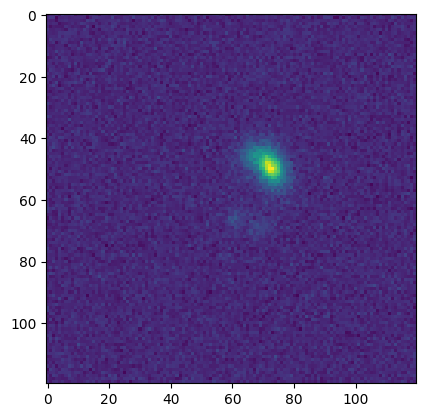

In [ ]:
# example blends
plt.imshow(blend_batch.blend_images[0, 0])

# Metrics

In BTK, we have three types of available metrics. The detection, segmentation, and reconstruction metrics. Each of them is available in its corresponding module:

In [ ]:
import btk.metrics.detection
import btk.metrics.segmentation
import btk.metrics.reconstruction

Let's talk first about the detection metrics, which were also mentioned in the quickstart tutorial notebooks. The metrics currently available include: 

- `Precision`
- `Recall` 
- `F1` 
- `Efficiency`

All of these metrics are subclass implementations of the same parent class `btk.metrics.detection.DetectionMetric`. In particular, these metrics all take three arrays as input `n_matches`, `n_true`, and `n_pred` where: 

- `n_matches`: An array where each element is the number of true positives matches for a given galaxy blend. 
- `n_true`: An array where each element is the number of galaxies for a given galaxy blend.
 - `n_pred`: An array where each element is the number of detections for a given galaxy blend.

 These three arrays are readily accessible from the output of the matcher as demonstrated below:

In [ ]:
from btk.match import PixelHungarianMatcher
from btk.metrics.detection import Recall, Precision

# create matcher
matcher = PixelHungarianMatcher(pixel_max_sep=5.0)

# get matching from the true and detections catalog
match = matcher(blend_batch.catalog_list, deblend_batch.catalog_list)

# compute precision and recall using the attributes of the matching
recall = Recall(match.batch_size)
precision = Precision(match.batch_size)
recall(match.tp, match.t, match.p), precision(match.tp, match.t, match.p)

(0.5365853658536586, 1.0)

Next, the segmentation metrics include only the `IoU` metric which can only be applied to the deblenders that output segmentation as part of their output. The `SepSingleBand` deblender does output segmentation information so we demonstrate its usage below with this output.

An important additional step compared to the detection metrics is that we need to apply the obtained matching to the arrays of images that we want to calculate the metric with. In this case, we need to apply it to the segmentation arrays. Note that there is no a priori segmentations for the true images, so we obtain them using the `btk.metrics.utils.get_segmentations` function which creates arrays corresponding to each individual galaxy image where each pixel gets turned to either `0` or `1` depending on whether that pixel is above the noise level of the image. Below is an example usage and image: 

In [ ]:
from btk.metrics.utils import get_segmentation
from galcheat.utilities import mean_sky_level

sky_level = mean_sky_level('LSST', 'r').to_value('electron') # gain = 1
true_segs = get_segmentation(blend_batch.isolated_images[:, :, 2], sky_level, sigma_noise=3)
true_segs.shape

(10, 7, 120, 120)

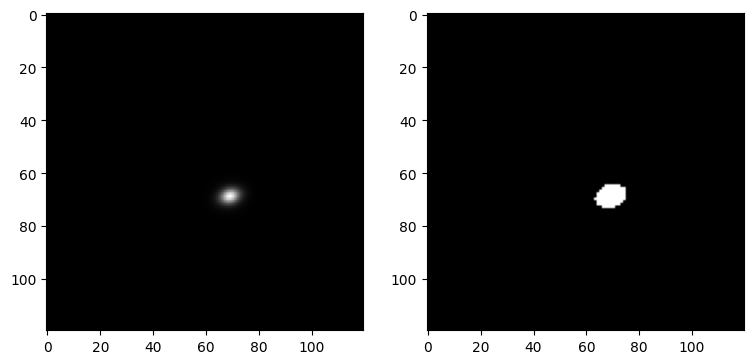

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))

ax1.imshow(blend_batch.isolated_images[0, 0, 2], cmap='gray')
ax2.imshow(true_segs[0, 0], cmap='gray')

Now we match the corresponding arrays using the method `match_true_arrays` and `match_pred_arrays` from the output `match` from running the `matcher` above: 

In [ ]:
segs1 = match.match_true_arrays(true_segs)
segs2 = match.match_pred_arrays(deblend_batch.segmentation)
segs1.shape, segs2.shape

((10, 3, 120, 120), (10, 3, 120, 120))

Now we can apply our segmentation metrics on these matched segmentations:

In [ ]:
from btk.metrics.segmentation import IoU

iou = IoU(match.batch_size)
iou(segs1, segs2) # automatically ignores unmached segmentation

0.7695449983946172

Finally, we demosntrate that a reconstruction metric such as mean squared error (`MSE`) can be applied in a similar fashing to the segmentation metric:

In [ ]:
from btk.metrics.reconstruction import MSE

recon1 = match.match_true_arrays(blend_batch.isolated_images[:, :, 2])
recon2 = match.match_pred_arrays(deblend_batch.deblended_images[:, :, 0]) # only r-band provided

MSE(batch_size)(recon1, recon2)

90.71579007756155

Note that the `MSE` metric can become diluted as the postage stamp size grows, as it does not exclude pixels far away from the galaxy centroid.

# Measure Functions

Another useful feature of BTK is that we provide a set of useful functions to compute quantities that might be useful in evaluating deblenders. In particular, we provide functions to compute: 

- Aperture photometry fluxes
- Blendedness
- Signal-to-noise ratio
- KSB Ellipticity

The corresponding functions can be accessed as follows:

In [ ]:
from btk.measure import get_aperture_fluxes, get_blendedness, get_snr, get_ksb_ellipticity

We demonstrate the usage of the blendedness measure function by creating a histogram of blendedness for our batch of galaxy blends (in the r-band). We require the isolated images of each galaxy, which are readily available from the `blend_batch`:

(array([15.,  9.,  0.,  2.,  2.,  1.,  5.,  2.,  1.,  4.]),
 array([0.        , 0.09393922, 0.18787845, 0.28181767, 0.3757569 ,
        0.46969612, 0.56363534, 0.65757457, 0.75151379, 0.84545301,
        0.93939224]),
 <BarContainer object of 10 artists>)

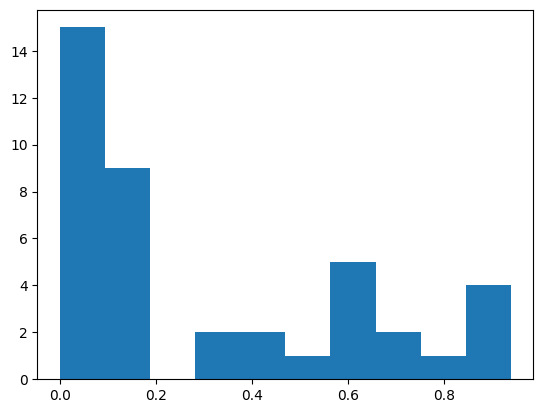

In [ ]:
blendedness = get_blendedness(blend_batch.isolated_images[:, :, 2]).flatten()

flux = blend_batch.isolated_images[:, :, 2].sum(axis=(-1, -2)).flatten()
mask = flux > 0 # exclude empty sources
plt.hist(blendedness[mask].flatten())

Which indicates a low degree of blendedness for most sources in our sample. Note that care is required to exclude "non-sources" from the final plot as `blend_batch.isolated_images` contains zero out images at the end of the array so that the isolated images array for each blend is the same size.

The signal-to-noise ratio (SNR) of our galaxies can also be easily computed, although we require pre-computing the sky level of our images that can be accomplished with the galcheat utility function: 

(array([2., 6., 8., 8., 4., 3., 0., 2., 0., 0.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

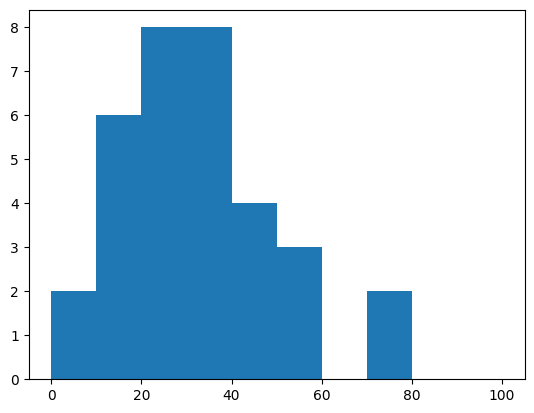

In [ ]:
from galcheat.utilities import mean_sky_level

background = mean_sky_level('LSST', 'r').to_value('electron')
snrs = get_snr(blend_batch.isolated_images[:, :, 2], background).flatten()

# same thing, exclude non-existant sources from calculation.
flux = blend_batch.isolated_images[:, :, 2].sum(axis=(-1, -2)).flatten()


plt.hist(snrs[flux > 0], bins=10, range=(0, 100))

# Matching

To end this tutorial notebook, we talk in more detail about the matching procedure that is available within BTK. 

The algorithms for matching are available at the `btk.match` module, we have implemented two types of matching algorithms that are available to use: 

- `btk.match.PixelHungarianMatcher`: Matching based on the Hungarian algorithm on pixel space, solving a minimization algorithm on the bipartite assignment.
- `btk.match.SkyClosestNeighbourMatcher`: Matching on sky coordinates based on the `astropy.coordinates` module via a nearest-neighbor algorithm using KD Trees.

As demonstrated above, any of the matchers can be readily used on the `catalog_list` objects corresponding the truth catalog and detections: 

In [ ]:
# create matcher
matcher = PixelHungarianMatcher(pixel_max_sep=5.0)

# get matching from the true and detections catalog
match = matcher(blend_batch.catalog_list, deblend_batch.catalog_list)

Most of the matchers will have as input the maximum separation that is used when assigning a match. In the case of the `PixelHungarianMatcher`, this separation is in pixels.

Lets examine the output of running the matcher on the catalog lists, which an object on its own, a `Matching` object. It contains useful properties that summarize the output of the matching procedure:

- `Matching.tp`: Number of true positive detections for each of the galaxy blends in the batch.
- `Matching.fp`: Number of false positive detections for each of the galaxy blends in the batch.
- `Matching.true_matches`: An index for each blend indicating which true object was matched with detections.
... 

These attributes can then be used to compute detection metrics or to appropriately reformat isolated and reconstructd image arrays so that 1-1 comparisons can be performed. For example, with its two types of functions: 

- `Matching.match_true_catalogs`: Aligns true catalogs with matched detection catalogs.
- `Matching.match_true_arrays`: Aligns arrays corresponding to true objects with matched detections.
- ...

Example usage for reconstructions, where we want to compare images of isolated galaxies that correspond to matched detections and true centroids: 

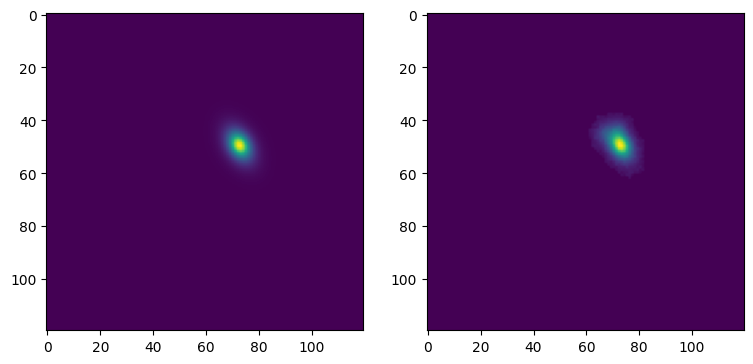

In [ ]:
recon1 = match.match_true_arrays(blend_batch.isolated_images[:, :, 2])
recon2 = match.match_pred_arrays(deblend_batch.deblended_images[:, :, 0]) # only r-band provided

# plot reconstruction to confirm they match
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
ax1.imshow(recon1[0, 1])
ax2.imshow(recon2[0, 1])